In [155]:
import pandas as pd
from IPython.display import display
# from tabulate import tabulate


# Load Datasets
movies = pd.read_csv('../data/movies.csv')
ratings = pd.read_csv('../data/ratings.csv')

# Display basic information
print("Movies Dataset :")
print("Row Count : ", movies.shape[0])
# print(movies.info())
# print(movies.head().to_string())
display(movies.head())
# print(tabulate(movies.head(), headers='keys', tablefmt='psql'))

print("\n\nRatings Dataset :")
# print(ratings.info())
print("Row Count : ", ratings.shape[0])
display(ratings.head())

num_total_ratings = len(ratings)

Movies Dataset :
Row Count :  87585


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy




Ratings Dataset :
Row Count :  32000204


,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [159]:
# Unique Genres
print("Unique movie genres : ", len(movies['genres'].unique()))
print("Unique movie titles : ", len(movies['title'].unique()))
print("Number of rows in movies : ", len(movies))

# Check for missing values
print("\nMissing values in movies dataset:")
print(movies.isnull().sum())


Unique movie genres :  1798
Unique movie titles :  87382
Number of rows in movies :  87585

Missing values in movies dataset:
movieId    0
title      0
genres     0
dtype: int64


In [161]:
print(ratings['rating'].value_counts().sort_index())

rating
0.5     525132
1.0     946675
1.5     531063
2.0    2028622
2.5    1685386
3.0    6054990
3.5    4290105
4.0    8367654
4.5    2974000
5.0    4596577
Name: count, dtype: int64


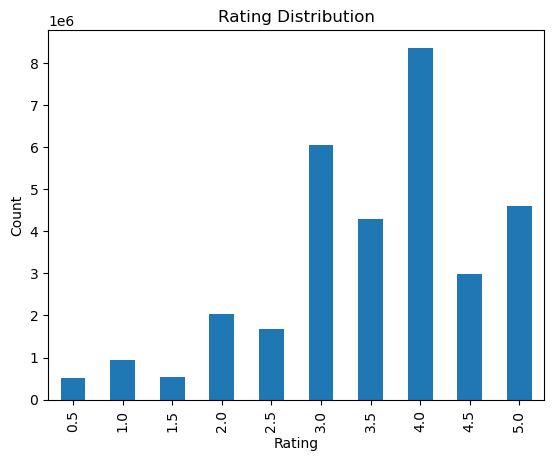


Number of unique users: 200948
Number of unique movies: 84432


In [163]:
# Rating distribution
import matplotlib.pyplot as plt

ratings['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Number of unique users and movies
print("\nNumber of unique users:", ratings['userId'].nunique())
print("Number of unique movies:", ratings['movieId'].nunique())

In [165]:
# Find duplicate titles
duplicate_movies = movies[movies.duplicated(subset='title', keep=False)]
duplicate_movie_ids = duplicate_movies['movieId']
print("Total number of duplicate movies : ", len(duplicate_movies))
num_unique_duplicate_movies = len(duplicate_movies['title'].unique())
print("Nmber of unique duplicate movies : ", num_unique_duplicate_movies)
print("Percentage of duplicate movies : ", 100 * num_unique_duplicate_movies/len(movies))

# Group duplicates by title
grouped_duplicates = duplicate_movies.groupby('title')

# Print each duplicate group
# for title, group in grouped_duplicates:
#     print(f"Duplicate Title: {title}")
#     print(group)
#     print("-" * 50)

Total number of duplicate movies :  401
Nmber of unique duplicate movies :  198
Percentage of duplicate movies :  0.22606610721013873


In [167]:
display(movies['genres'].head())
# display(movies.groupby('title')['genres'].head())

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

In [169]:
# Duplicate movies make up only 0.2% of the entire dataset but I still want to clean them up
print(len(duplicate_movies['movieId'].unique()))

'''
Consolidate Genres for duplicates with overlapping or invalid genres:
	1.	Combine all genres for the same title, removing duplicates.
	2.	Exclude invalid genres like (no genres listed).
                          '''
# Consolidate genres by combining unique genres for duplicate titles
def consolidate_genres(group):
    # Split and explode genres
    genres = group.str.split('|').explode()

    # Filter out invalid genres
    valid_genres = genres[genres != '(no genres listed)']

    # Combine unique genres into a sorted, pipe-separated string
    return '|'.join(sorted(set(valid_genres)))

# Apply consolidation
# print(":::::::: Null movie genre columns => ", len(movies[movies['genres'].isnull()]))
movies['genres'] = movies.groupby('title')['genres'].transform(consolidate_genres)
display(movies['genres'].head())

401


0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

In [171]:
# Average the ratings for duplicate movieIds
# Filter ratings for duplicate movies
num_total_ratings = len(ratings)
duplicate_ratings = ratings[ratings['movieId'].isin(duplicate_movie_ids)]
num_duplicate_ratings = len(duplicate_ratings)
print(":::::: Number of ratings => ", num_total_ratings)
print(":::::: Number of duplicate ratings => ", num_duplicate_ratings)
print(":::::: Percentage of duplicate ratings => ", 100*num_duplicate_ratings/num_total_ratings)

:::::: Number of ratings =>  32000204
:::::: Number of duplicate ratings =>  98410
:::::: Percentage of duplicate ratings =>  0.30752928950077946


In [175]:
# Duplicate ratings make up only 0.3% of the dataset but I will clean them up anyway.

# Function to round to the nearest 0.5
def round_to_nearest_half(value):
    rounded_value = round(value * 2) / 2
    # print(f":::: Value => {value}, Rounded => {rounded_value}")
    return rounded_value

# Compute average ratings for duplicate movies
avg_duplicate_ratings = duplicate_ratings.groupby('movieId')['rating'].mean()

# Apply the rounding function to the averaged ratings
avg_dup_ratings_rounded = avg_duplicate_ratings.apply(round_to_nearest_half)

# Replace ratings for duplicate movies with the average rating
ratings.loc[ratings['movieId'].isin(avg_dup_ratings_rounded.index), 'rating'] = ratings['movieId'].map(avg_dup_ratings_rounded)

print("::::: Updated average ratings for duplicate movies !!!")


::::: Updated average ratings for duplicate movies !!!


In [177]:
print(ratings['rating'].value_counts().sort_index())

rating
0.5     523673
1.0     944384
1.5     529474
2.0    2023842
2.5    1682648
3.0    6054831
3.5    4343898
4.0    8345829
4.5    2967014
5.0    4584611
Name: count, dtype: int64


In [179]:
# Remove rows with missing essential data
print("::::::::::: Number of movies before dropping nulls and duplicates : ", len(movies))
movies = movies.dropna(subset=['title', 'genres'])
# Drop duplicates based on titles
movies = movies.drop_duplicates(subset='title', keep='first').reset_index(drop=True)
print("::::::::::: Number of movies after dropping nulls and duplicates : ", len(movies))


::::::::::: Number of movies before dropping nulls and duplicates :  87585
::::::::::: Number of movies after dropping nulls and duplicates :  87382


In [181]:
# Verify there are no more duplicates
print("Total number of duplicate movies : ", len( movies[movies.duplicated(subset='title', keep=False)]))

Total number of duplicate movies :  0


In [183]:
#Normalize Titles
movies['title'] = movies['title'].str.lower().str.strip()

In [185]:
display(movies.head())

,movieId,title,genres
0,1,toy story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,jumanji (1995),Adventure|Children|Fantasy
2,3,grumpier old men (1995),Comedy|Romance
3,4,waiting to exhale (1995),Comedy|Drama|Romance
4,5,father of the bride part ii (1995),Comedy


In [187]:
# Aggregate ratings per movie
movie_ratings = ratings.groupby('movieId')['rating'].count().reset_index()
movie_ratings.rename(columns={'rating': 'rating_count'}, inplace=True)

display(movie_ratings.head())

# Merge with movies dataset
popular_movies = movie_ratings.merge(movies, on='movieId').sort_values(by='rating_count', ascending=False)

print("Top 10 most popular movies:")
display(popular_movies.head(10))

,movieId,rating_count
0,1,68997
1,2,28904
2,3,13134
3,4,2806
4,5,13154


Top 10 most popular movies:


,movieId,rating_count,title,genres
314,318,102929,"shawshank redemption, the (1994)",Crime|Drama
351,356,100296,forrest gump (1994),Comedy|Drama|Romance|War
292,296,98409,pulp fiction (1994),Comedy|Crime|Drama|Thriller
2480,2571,93808,"matrix, the (1999)",Action|Sci-Fi|Thriller
585,593,90330,"silence of the lambs, the (1991)",Crime|Horror|Thriller
257,260,85010,star wars: episode iv - a new hope (1977),Action|Adventure|Sci-Fi
2867,2959,77332,fight club (1999),Action|Crime|Drama|Thriller
475,480,75233,jurassic park (1993),Action|Adventure|Sci-Fi|Thriller
522,527,73849,schindler's list (1993),Drama|War
4888,4993,73122,"lord of the rings: the fellowship of the ring,...",Adventure|Fantasy


In [189]:
# Aggregate average rating per movie
avg_ratings = ratings.groupby('movieId')['rating'].mean().reset_index()
avg_ratings.rename(columns={'rating': 'average_rating'}, inplace=True)

# Merge with movies dataset
highest_rated = avg_ratings.merge(movies, on='movieId').sort_values(by='average_rating', ascending=False)

print("Top 10 highest rated movies:")
display(highest_rated[['title', 'average_rating']].head(10))

Top 10 highest rated movies:


,title,average_rating
36015,hart to hart returns (1993),5.0
34850,neapolitan diary (1992),5.0
58157,the stolen caravaggio (2018),5.0
34964,she who must burn,5.0
72910,indianara (2019),5.0
50035,the painting (2001),5.0
50034,the hostage (1967),5.0
50029,thirty proof coil (2011),5.0
25523,styx (2001),5.0
25520,the millennium bug (2011),5.0


In [191]:
missing_genres_count = movies['genres'].isnull().sum()
print("Count of movies with missing genres:", missing_genres_count)

Count of movies with missing genres: 0


In [193]:
# Fill missing genres with "Unknown"
movies['genres'] = movies['genres'].fillna('Unknown')

# Extract release year (if present in the title)
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies['year'] = pd.to_numeric(movies['year'], errors='coerce')
movies['year'] = movies['year'].fillna(0).astype(int)

display(movies.head(10))

,movieId,title,genres,year
0,1,toy story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,jumanji (1995),Adventure|Children|Fantasy,1995
2,3,grumpier old men (1995),Comedy|Romance,1995
3,4,waiting to exhale (1995),Comedy|Drama|Romance,1995
4,5,father of the bride part ii (1995),Comedy,1995
5,6,heat (1995),Action|Crime|Thriller,1995
6,7,sabrina (1995),Comedy|Romance,1995
7,8,tom and huck (1995),Adventure|Children,1995
8,9,sudden death (1995),Action,1995
9,10,goldeneye (1995),Action|Adventure|Thriller,1995


In [195]:
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87382 entries, 0 to 87381
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  87382 non-null  int64 
 1   title    87382 non-null  object
 2   genres   87382 non-null  object
 3   year     87382 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.7+ MB
None


In [199]:
# Movies with a rating count of less than 10
count_less_than_10 = popular_movies[popular_movies['rating_count'] < 10].shape[0]
print(count_less_than_10)

52325


In [201]:
# Find the number of times each user has rated a movie
user_rating_counts = ratings.groupby('userId')['rating'].count()
filtered_users = user_rating_counts[user_rating_counts >= 5].index
print(len(filtered_users))

200948


In [205]:
# Filter movies with less than 10 ratings
filtered_movies = movie_ratings[movie_ratings['rating_count'] >= 10]['movieId']
ratings = ratings[ratings['movieId'].isin(filtered_movies)]

# Filter users with less than 5 ratings
user_rating_counts = ratings.groupby('userId')['rating'].count()
filtered_users = user_rating_counts[user_rating_counts >= 5].index
ratings = ratings[ratings['userId'].isin(filtered_users)]


In [207]:
print("Filtered ratings shape:", ratings.shape)
print("::: New ratings count => ", ratings.shape[0])

Filtered ratings shape: (31842705, 4)
::: New ratings count =>  31842705


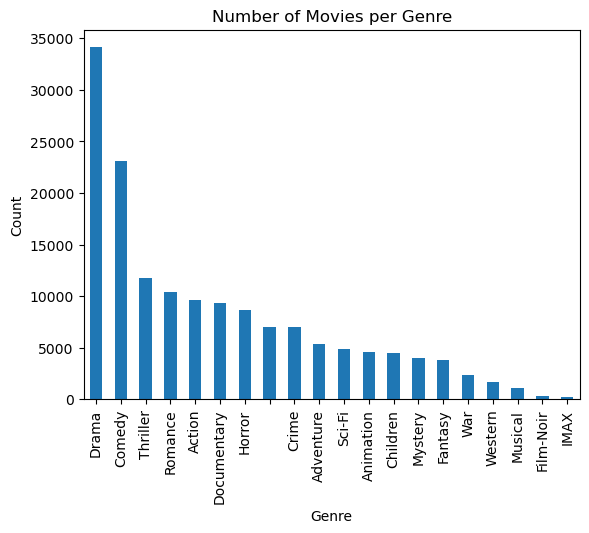

In [209]:
# Number of movies per genre
movies['genre_list'] = movies['genres'].str.split('|')
all_genres = [genre for sublist in movies['genre_list'] for genre in sublist]
genre_counts = pd.Series(all_genres).value_counts()

# Plot
genre_counts.plot(kind='bar')
plt.title('Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

In [211]:
display(genre_counts.head(10))
display(movies.head(10))

Drama          34130
Comedy         23110
Thriller       11798
Romance        10364
Action          9662
Documentary     9353
Horror          8647
                7050
Crime           6972
Adventure       5398
Name: count, dtype: int64

,movieId,title,genres,year,genre_list
0,1,toy story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,jumanji (1995),Adventure|Children|Fantasy,1995,"[Adventure, Children, Fantasy]"
2,3,grumpier old men (1995),Comedy|Romance,1995,"[Comedy, Romance]"
3,4,waiting to exhale (1995),Comedy|Drama|Romance,1995,"[Comedy, Drama, Romance]"
4,5,father of the bride part ii (1995),Comedy,1995,[Comedy]
5,6,heat (1995),Action|Crime|Thriller,1995,"[Action, Crime, Thriller]"
6,7,sabrina (1995),Comedy|Romance,1995,"[Comedy, Romance]"
7,8,tom and huck (1995),Adventure|Children,1995,"[Adventure, Children]"
8,9,sudden death (1995),Action,1995,[Action]
9,10,goldeneye (1995),Action|Adventure|Thriller,1995,"[Action, Adventure, Thriller]"


In [213]:
# Combine relevant features
movies['combined_features'] = movies['title'] + " " + movies['genres']
display(movies.head(10))

,movieId,title,genres,year,genre_list,combined_features
0,1,toy story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,"[Adventure, Animation, Children, Comedy, Fantasy]",toy story (1995) Adventure|Animation|Children|...
1,2,jumanji (1995),Adventure|Children|Fantasy,1995,"[Adventure, Children, Fantasy]",jumanji (1995) Adventure|Children|Fantasy
2,3,grumpier old men (1995),Comedy|Romance,1995,"[Comedy, Romance]",grumpier old men (1995) Comedy|Romance
3,4,waiting to exhale (1995),Comedy|Drama|Romance,1995,"[Comedy, Drama, Romance]",waiting to exhale (1995) Comedy|Drama|Romance
4,5,father of the bride part ii (1995),Comedy,1995,[Comedy],father of the bride part ii (1995) Comedy
5,6,heat (1995),Action|Crime|Thriller,1995,"[Action, Crime, Thriller]",heat (1995) Action|Crime|Thriller
6,7,sabrina (1995),Comedy|Romance,1995,"[Comedy, Romance]",sabrina (1995) Comedy|Romance
7,8,tom and huck (1995),Adventure|Children,1995,"[Adventure, Children]",tom and huck (1995) Adventure|Children
8,9,sudden death (1995),Action,1995,[Action],sudden death (1995) Action
9,10,goldeneye (1995),Action|Adventure|Thriller,1995,"[Action, Adventure, Thriller]",goldeneye (1995) Action|Adventure|Thriller


In [217]:
# Save Cleaned Data

movies.to_csv('../data/cleaned_movies.csv', index=False)
ratings.to_csv('../data/cleaned_ratings.csv', index=False)

In [221]:
# In the next few steps, we remap movie and ratings indexes for consistency and memory efficiency when working with matrices and vectors

import pandas as pd

# Load cleaned ratings data
ratings = pd.read_csv('../data/cleaned_ratings.csv')
movies = pd.read_csv('../data/cleaned_movies.csv')

print("Ratings Shape:", ratings.shape)
print("Movies Shape:", movies.shape)

Ratings Shape: (31842705, 4)
Movies Shape: (87382, 6)


In [225]:
# Check if Movie IDs are unique and sequential
print("Unique movie IDs from movies : ", movies['movieId'].nunique())
print("Max Movie ID from movies : ", movies['movieId'].max(), "\n")

print("Unique movie IDs from ratings : ", ratings['movieId'].nunique())  # Should match the total number of unique movies
print("Max Movie ID from ratings : ", ratings['movieId'].max(), "\n")     # Should equal ratings['movieId'].nunique() - 1

print("Unique User IDs from ratings : ", ratings['userId'].nunique(), "\n") 

unique_movie_ids = ratings['movieId'].unique()
print("Key : Value mapping for sequential movie IDs")
for index, value in enumerate(unique_movie_ids[:10]):
    print(f"Index: {index}, Value: {value}")

Unique movie IDs from movies :  87382
Max Movie ID from movies :  292757 

Unique movie IDs from ratings :  31961
Max Movie ID from ratings :  292349 

Unique User IDs from ratings :  200948 

Key : Value mapping for sequential movie IDs
Index: 0, Value: 17
Index: 1, Value: 25
Index: 2, Value: 29
Index: 3, Value: 30
Index: 4, Value: 32
Index: 5, Value: 34
Index: 6, Value: 36
Index: 7, Value: 80
Index: 8, Value: 110
Index: 9, Value: 111


In [227]:
# A sparse matrix with 292,350 columns for only 31,961 unique movies wastes memory. 
# The additional empty columns increase computation time for operations like matrix factorization.
# Other parts of the recommendation system (like movies metadata) rely on sequential indices so this misalignment will cause issues when mapping between datasets.
# To fix this, we will need to remap movieId values to sequential indices in the next step


# Create a mapping of unique movie IDs to sequential indices
# unique_movie_ids = ratings['movieId'].unique()
movie_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_movie_ids)}

# Apply the mapping
ratings['movieId'] = ratings['movieId'].map(movie_id_map)
print("Max Movie ID from ratings : ", ratings['movieId'].max(), "\n\n")

Max Movie ID from ratings :  31960 




In [229]:
''' Since we have remapped movie IDs in ratings to be sequential, we also need to do the same for movies['movieId'] using the same mapping because:
# 1. We will be looking up movies by the same ID in movies['movieId'] so alignment is crucial
# 2. Since ratings['movieId'] has been remapped, the original movieId values are replaced. Without remapping movies['movieId'], 
we would lose the ability to map recommendations back to their metadata (e.g., titles).
# 3. Misaligned IDs can lead to incorrect recommendations because the indices will point to the wrong rows in movies.
# We will follow the same pattern we used for ratings
'''

movies['movieId'] = movies['movieId'].map(movie_id_map)
print("Max Movie ID from movies : ", movies['movieId'].max(), "\n\n")

Max Movie ID from movies :  31960.0 




In [231]:
# Save remapped movie and ratings datasets
ratings.to_csv('../data/cleaned_remapped_ratings.csv', index=False)
movies.to_csv('../data/cleaned_remapped_movies.csv', index=False)

print("Saved remapped movies and ratings !!!")

Saved remapped movies and ratings !!!
